### Streaming edge detection algorithm

The robust edge detection algorithm uses a derivative of Gaussian function to convolve with the original time series to find edge signal in the precense of noise. The illustration of the algorithm is shown as follows:
![Gaussian Derivative](figure/algorithm.png "Gaussian derivatives")

Notes on streaming adaptation of the edge detection algorithm:
1. Edge threshold: if abs(d_gaussian[x]) > ma * threshold. threshold = 3.0 gives good results in experiment
2. Since Gaussian smoothing is applied, a latency in edge detection relative to the lastest data point. The latency is width_of_gaussian_window/2+1.
3. Since Gaussian smoothing also smooth the edge signal, local maxima/minima search is used to find the exactly edge position.

Heuristics are used to improve edge detection results on square waves:
- Heuristic 1: two edges of the same sign cannot be as close as 10 data points.
- Heuristic 2: edges of positive and negative signs should always alternating (for square wave in partiticular)
- Heuristic 3: moving average ma update rule: ma = (1-alpha) * ma + alpha * abs(d_gaussian[x]), alpha=0.05.
- Heuristic 4: Always update ma on first 20 data points to estiabish a baseline. After that, only update ma when d_gaussian[x] less than edge threshold.  


In [43]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import json
from pandas import Series
from pandas import Timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy import stats 
%matplotlib inline

In [44]:
def streaming_edge_detection(x, sigma=2.0, threshold=3.0, visualize=False, additional_title=""):
    '''
    streaming edge detection algorithm on signal x
    @param x: original time series
    @param sigma: sigma of Guassian smooth filter, default=2.0
    @param threshold: threshold for edge detection. dx > ma * thresohld, default=3.0
    @return list of edge tuples [(sign, position)], e.g. [("+", 20), ("-", 30)]
    '''
    alpha = 0.05
    width = int(3*sigma)
    edges = []
    min_dist = 20 # min distance of two edges of the same sign
    
    gaussian = signal.gaussian(width*2+1, sigma)
    d1_gaussian = signal.convolve(gaussian, [-1, 0 , 1], mode='same')
    ma = 0
    edge_pos = []
    edge_val = []
    last_positive = -1
    last_negative = -1
    last_sign = 0
    
    derivative = np.zeros(len(x))
    dx_buffer = np.zeros(3)
    ma_buffer = np.zeros(len(x))
    
    # convolve signal x with d1_guassian window
    for n in range(5, len(x)-5):
        dx = 0
        if sigma > 0:
            # convolve sum first half
            for k in range(1, width+1):
                dx += d1_gaussian[width-k] * x[n-k] if n >= k else 0 
            # middle point
            dx += x[n] * d1_gaussian[width]
            # convolve sum second half
            for k in range(1, width+1):
                dx += d1_gaussian[width+k] * x[n+k] if n+k < len(x) else 0
        else:
            # no smoothing at all
            dx = x[n] - x[n-1]
        derivative[n] = dx 
        # buffer shift
        dx_buffer[0] = dx_buffer[1]
        dx_buffer[1] = dx_buffer[2]
        dx_buffer[2] = dx
        if n < 20:
            ma = (1-alpha) * ma + alpha * abs(dx)
        else:
            
            if dx_buffer[1] > ma * threshold:
                # find local max
                if dx_buffer[1] >= dx_buffer[2] and dx_buffer[1] >= dx_buffer[0]:
                    if n-1 - last_positive > min_dist and last_sign <= 0:
                        edges.append(("+", n-1))
                        edge_pos.append(n-1)
                        edge_val.append(dx_buffer[1])
                        last_positive = n-1
                        last_sign = +1
                    
            elif dx_buffer[1] < -ma * threshold:
                # find local min
                if dx_buffer[1] <= dx_buffer[2] and dx_buffer[1] <= dx_buffer[0]:
                    if n-1 - last_negative > min_dist and last_sign >= 0:
                        edges.append(("-", n-1))
                        edge_pos.append(n-1)
                        edge_val.append(dx_buffer[1])
                        last_negative = n-1
                        last_sign = -1
            if abs(dx_buffer[1]) <= 1.5 * ma: 
                # only update ma for data points below low threshold
                ma = (1-alpha) * ma + alpha * abs(dx)   
            ma_buffer[n] = ma
    if visualize:
        plt.style.use('seaborn-paper')
        fig = plt.figure(figsize=(18,15))
        ax1 = fig.add_subplot(3,1,1)
        ax1.plot(x)
        ax1.set_title("Original signal: {}".format(additional_title))
        ax2 = fig.add_subplot(3,1,2)
        ax2.plot(derivative)
        ax2.plot(np.zeros(len(x)))
        ax2.plot(edge_pos, edge_val,"o", label="detected edge positions")
        #ax2.legend(loc="lower left")
        ax2.set_title("Gaussian derivative signal and edge detector results")
        #ax3 = fig.add_subplot(3,1,3)
        #ax3.plot(ma_buffer)
    return edges
    

### Evaluation of edge detection algoirthm
Given a list of ground truth edge positions and a list of detected edge results. We define:
- True positive (TP): if both edge sign and position matches. We tolerate 1 datapoint accuracy error in edge position.
- False positive (FP): if there is no grouth truth edge at detected edge position.
- False Negative (FN): if the detector missed a grouth-truth edge or the sign is opposite.

We report both **precision** = TP/(TP + FP) and **recall** = TP/(TP + FN) rate.

In [45]:
def edge_evaluate(gt_edges, dt_edges):
    delta = 1 # tolerant +-1 edge position error
    tp = 0   # matching edges
    fp = 0   # non-existing edges
    fn = 0   # missing ground truth edges

    gt_num = len(gt_edges)
    dt_num = len(dt_edges)

    #print("Expected edges={}, detected edges={}".format(gt_num, dt_num))
    #for n in range(max(gt_num, dt_num)):
    #    print("{}, {}".format(gt_edges[n] if n < gt_num else "       ", dt_edges[n] if n < dt_num else ""))
    j = 0
    i = 0
    while i < len(gt_edges) and j < len(dt_edges):
        gt_pos = gt_edges[i][1]
        dt_pos = dt_edges[j][1]
        gt_sign = gt_edges[i][0]
        dt_sign = dt_edges[j][0]
        if abs(gt_pos - dt_pos) <= delta:
            if gt_sign == dt_sign:
                tp += 1
            else:
                fn += 1
            i += 1
            j += 1
        elif gt_pos > dt_pos + delta:
            j += 1 # advance dt
            fp += 1
        elif gt_pos < dt_pos - delta:
            i += 1 # advance gt
            fn += 1

    fn += len(gt_edges) - i
    fp += len(dt_edges) - j

    if tp == 0:
        return 0,0
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return precision, recall


### Experiment on synthetic square waves with increasing noise level
The synthetic square wave with amplitude=1000 is used in the experiment. 
I gradually add white noise of ~ noise_amp * N(0,1) to the square wave signal, noise_amp range from [0, 500]

Algorithm parameter: Gaussian sigma=2.0, threshold = 3.0.

At each noise level, the experiment is repeated 10 times and average precision and recall rate are reported to generate the precision/recall curves at different noise level.

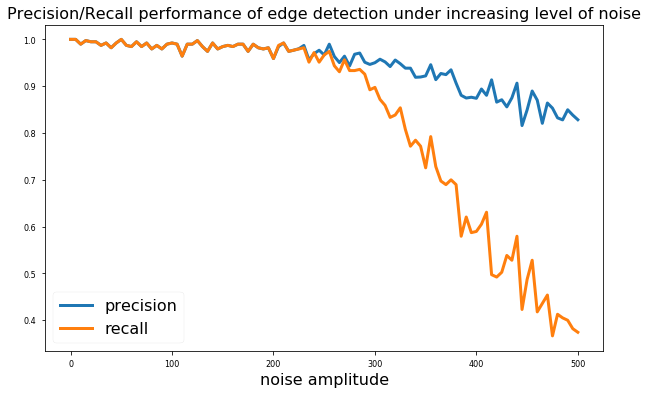

In [46]:
t = np.arange(0,1000)
linear = 5 * t
square = 500 * (signal.square(2 * np.pi / 50 * (t + 25), 0.5))
x_clean =  square #+ linear

# edge detector parameter 
threshold = 5.0 # edge if dx > threshold * ma
sigma = 2.0 # gaussian smooth sigma
nround = 10

precisions = []
recalls = []
noise_amps = np.arange(0,501,5)

for noise_amp in noise_amps:
    mean_precision = 0
    mean_recall = 0
    for n in range(nround):
        noise = noise_amp * np.random.normal(0, 1.0, len(t))
        x_noisy = x_clean + noise
        gt_edges = streaming_edge_detection(x_clean, 0, threshold, False)
        dt_edges = streaming_edge_detection(x_noisy, sigma, threshold, False)
        precision, recall = edge_evaluate(gt_edges, dt_edges)
        mean_precision += precision
        mean_recall += recall
    
    mean_precision /= nround
    mean_recall /= nround
    precisions.append(mean_precision)
    recalls.append(mean_recall)
    #print("NoiseAmp={},Precision={}, recall={}".format(noise_amp, precision, recall))

plt.style.use('seaborn-paper')
fig = plt.figure(figsize=(10,6))
plt.plot(noise_amps, precisions, linewidth=3.0, label='precision')
plt.plot(noise_amps, recalls, linewidth=3.0, label='recall')
plt.legend(loc='lower left', fontsize=16)
plt.xlabel("noise amplitude", fontsize=16)
plt.title("Precision/Recall performance of edge detection under increasing level of noise", fontsize=16)


### Results analysis

The edge detection has close to perfect performance with noise <=200. After 200 noise amp, the recall degrades much quicker than precision, which means the edge detector finds lots more *false negative* (missing true edges) than *false positive* (wrong edges due to noise)

![precision_recall_curve_analysis](figure/precision_recall.png)

### Illustration of edge detection results at three critical noise levels
- noise_amp = 0: ground true edge positions are computed from this square waves with no noise
- noise_amp = 200: this is the upper limit noise level for close to perfect edge detection
- noise_amp = 500: with severe noise, edge detection missing lots of true edges

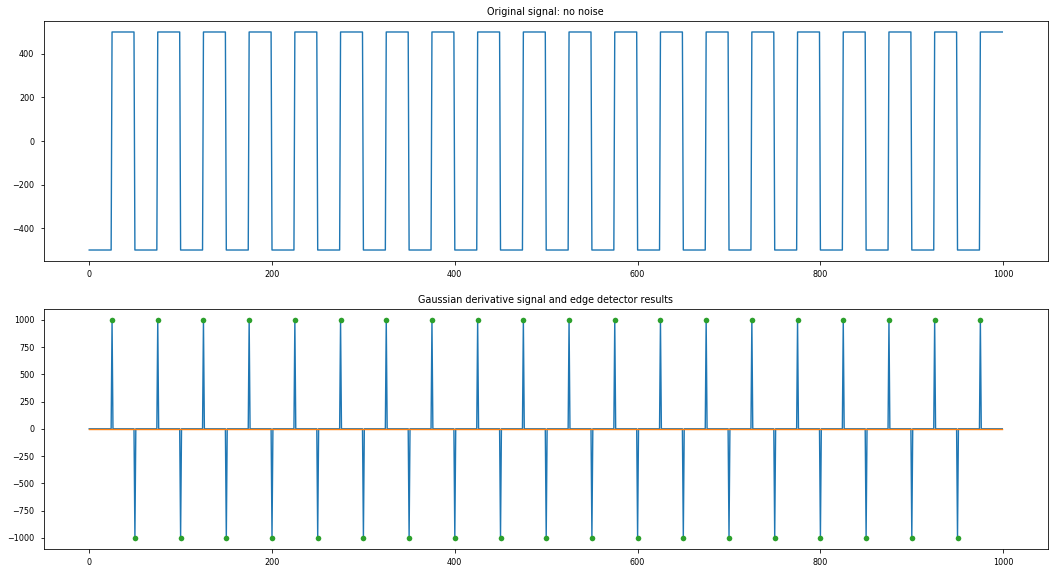

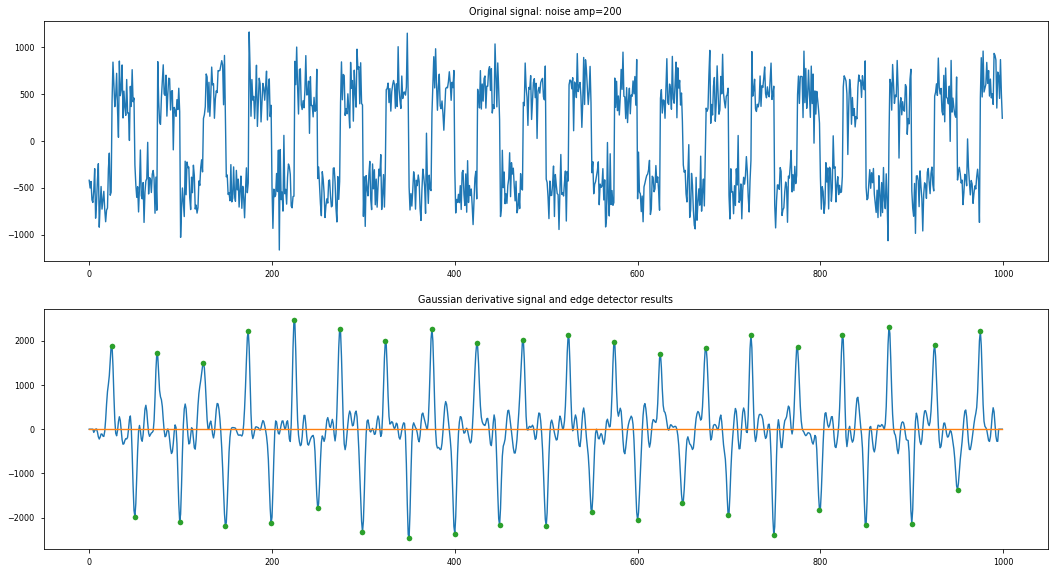

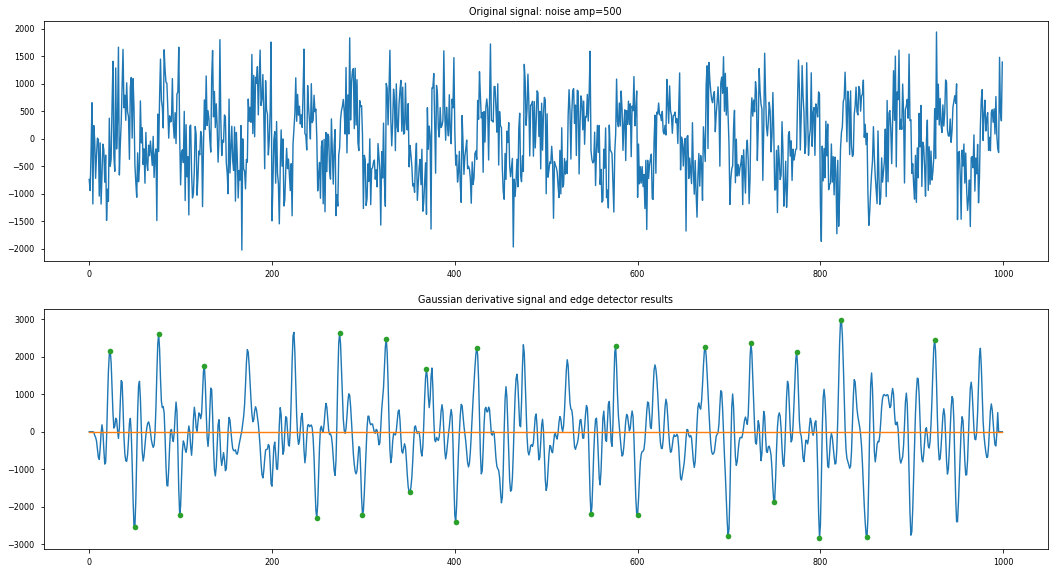

In [47]:
gt_edges = streaming_edge_detection(x_clean, 0, threshold, True, "no noise")
noise = 200 * np.random.normal(0, 1.0, len(t))
x_noisy = x_clean + noise
dt_edges = streaming_edge_detection(x_noisy, sigma, threshold, True, "noise amp=200")
noise = 500 * np.random.normal(0, 1.0, len(t))
x_noisy = x_clean + noise
dt_edges = streaming_edge_detection(x_noisy, sigma, threshold, True, "noise amp=500")

### Evaluate on a real noisy metric:
There are five daily high workloads in this time series, but the data is quite noisy. 

It is challenging for edge detection algorithm. Finally get it right after lots of tuning. 
I did a heavy smoothing sigma=5.0 and strong threshold = 20

I don’t think there is a general adaptive way. It depends on the level of noise and the significance of the edge.

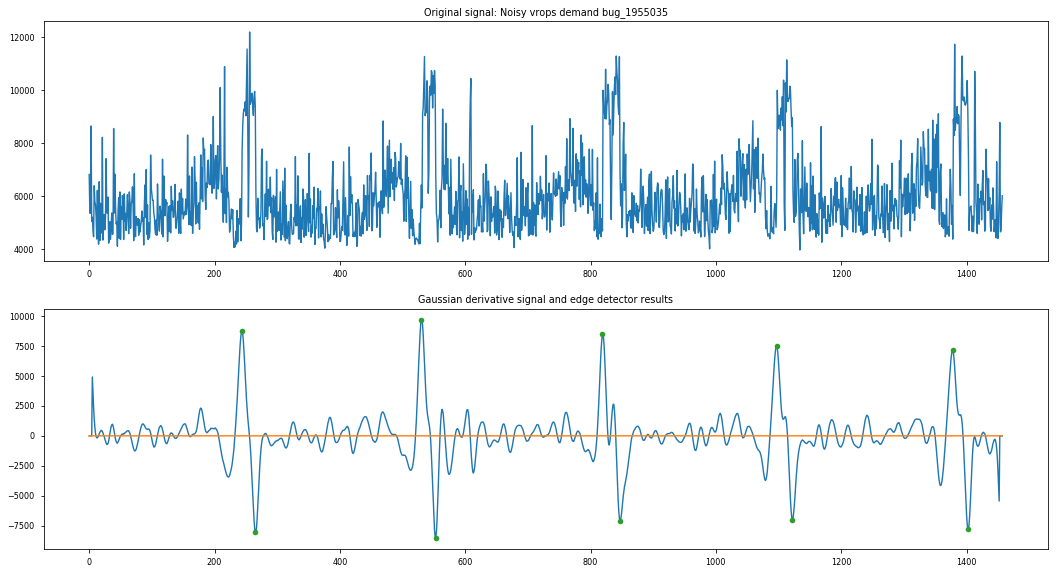

In [50]:
table = pd.read_csv("data/noisy_demand.csv", header=0, index_col=0, parse_dates=True)
ts = Series(table["Value"])
real_noisy = ts.values
dt_edges = streaming_edge_detection(real_noisy, 5.0, 20.0, True, "Noisy vrops demand bug_1955035")
